In [143]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline

In [144]:
df=pd.read_csv('Bank_Personal_Loan_Modelling.csv')
df.head(2)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0


In [145]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [147]:
df.drop(['ID','ZIP Code'], axis=1, inplace=True) 

In [148]:
df[df['Experience']<0]['Experience'].value_counts()

Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

In [149]:
df['Experience'] = df['Experience'].apply(abs)

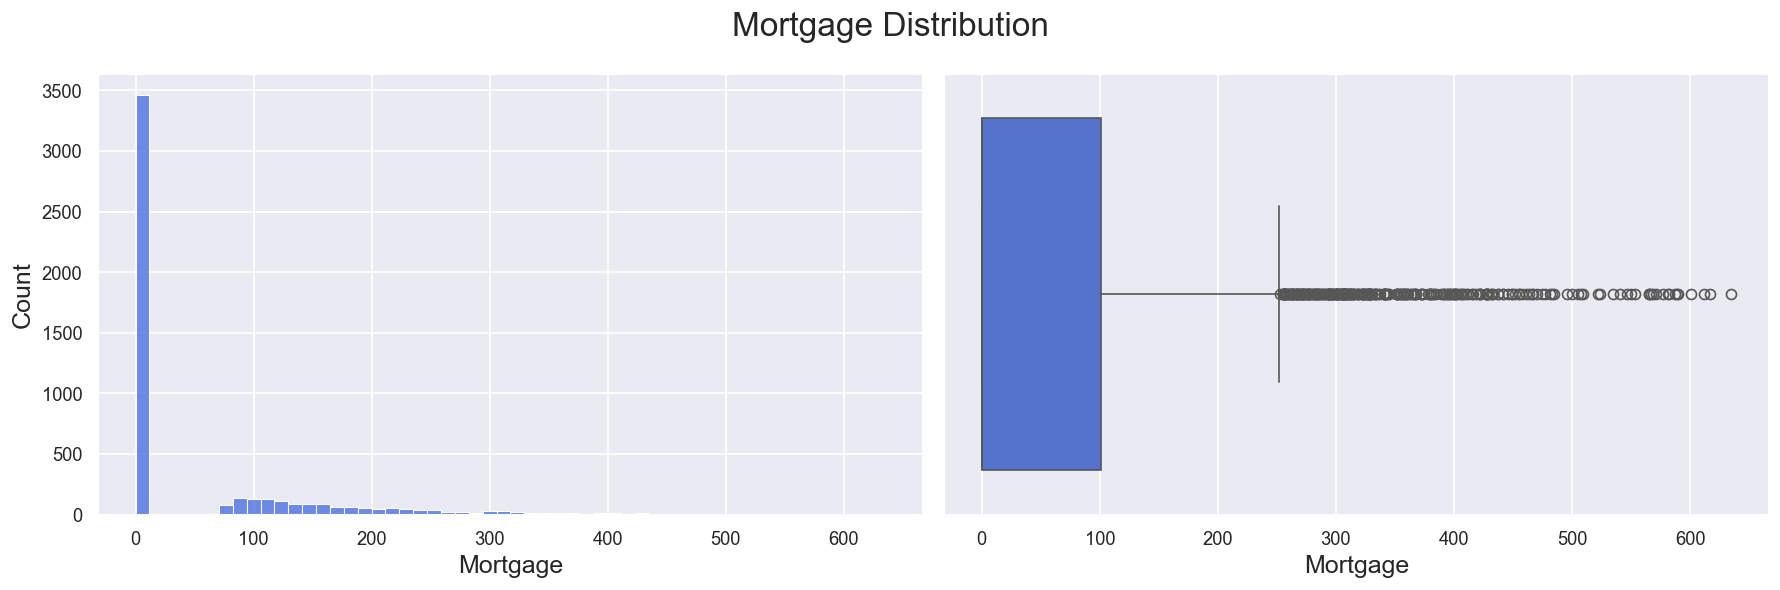

In [150]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [151]:
from scipy import stats
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

np.int64(105)

In [152]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

In [153]:
df['CCAvg'] = df['CCAvg']*12

In [154]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

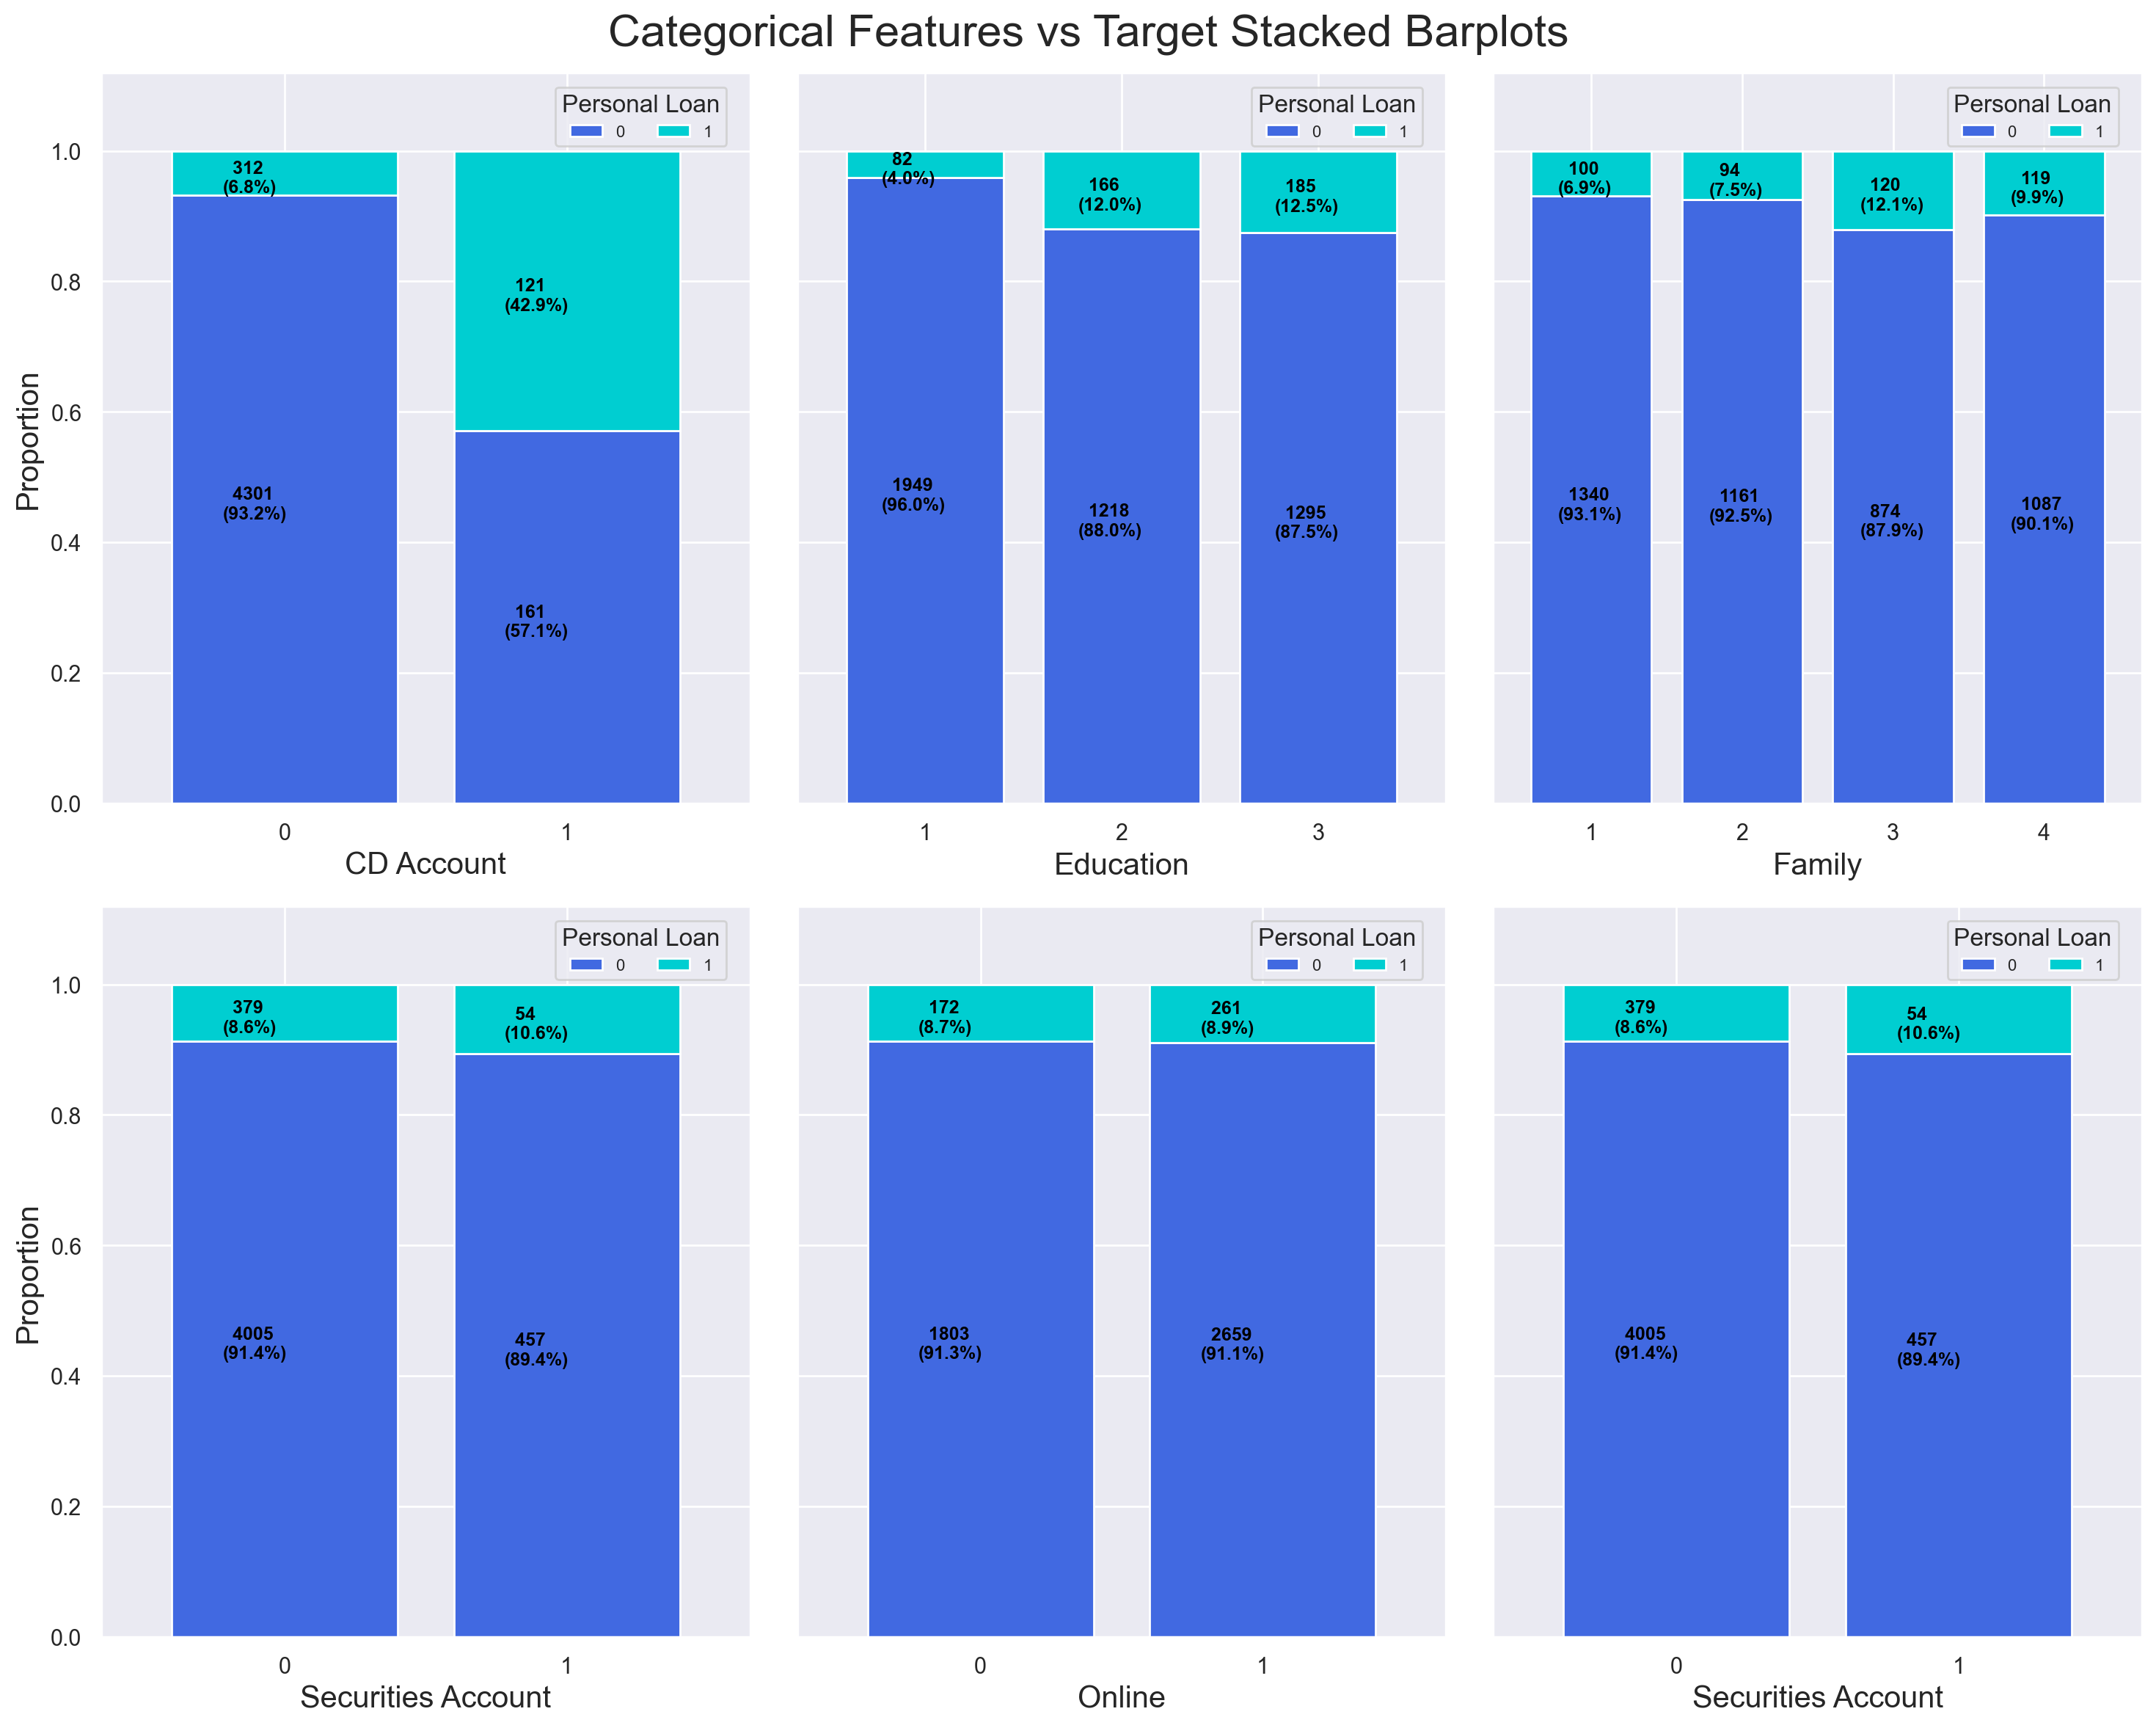

In [155]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

The customer who has a certificate of deposit (CD) with the bank appears to buy personal loans from the bank.

Customers with higher levels of education are more likely to buy personal loans.

The number of family members has no significant effect on the probability of buying personal loans.

Customers who have or do not have a securities account at the bank have no influence on the probability of buying a personal loan.

The customer who uses or does not use internet banking does not seem to have any influence on the probability of buying a personal loan.

The customer who uses or does not use a credit card does not appear to have an impact on the likelihood of purchasing a personal loan.

In [156]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

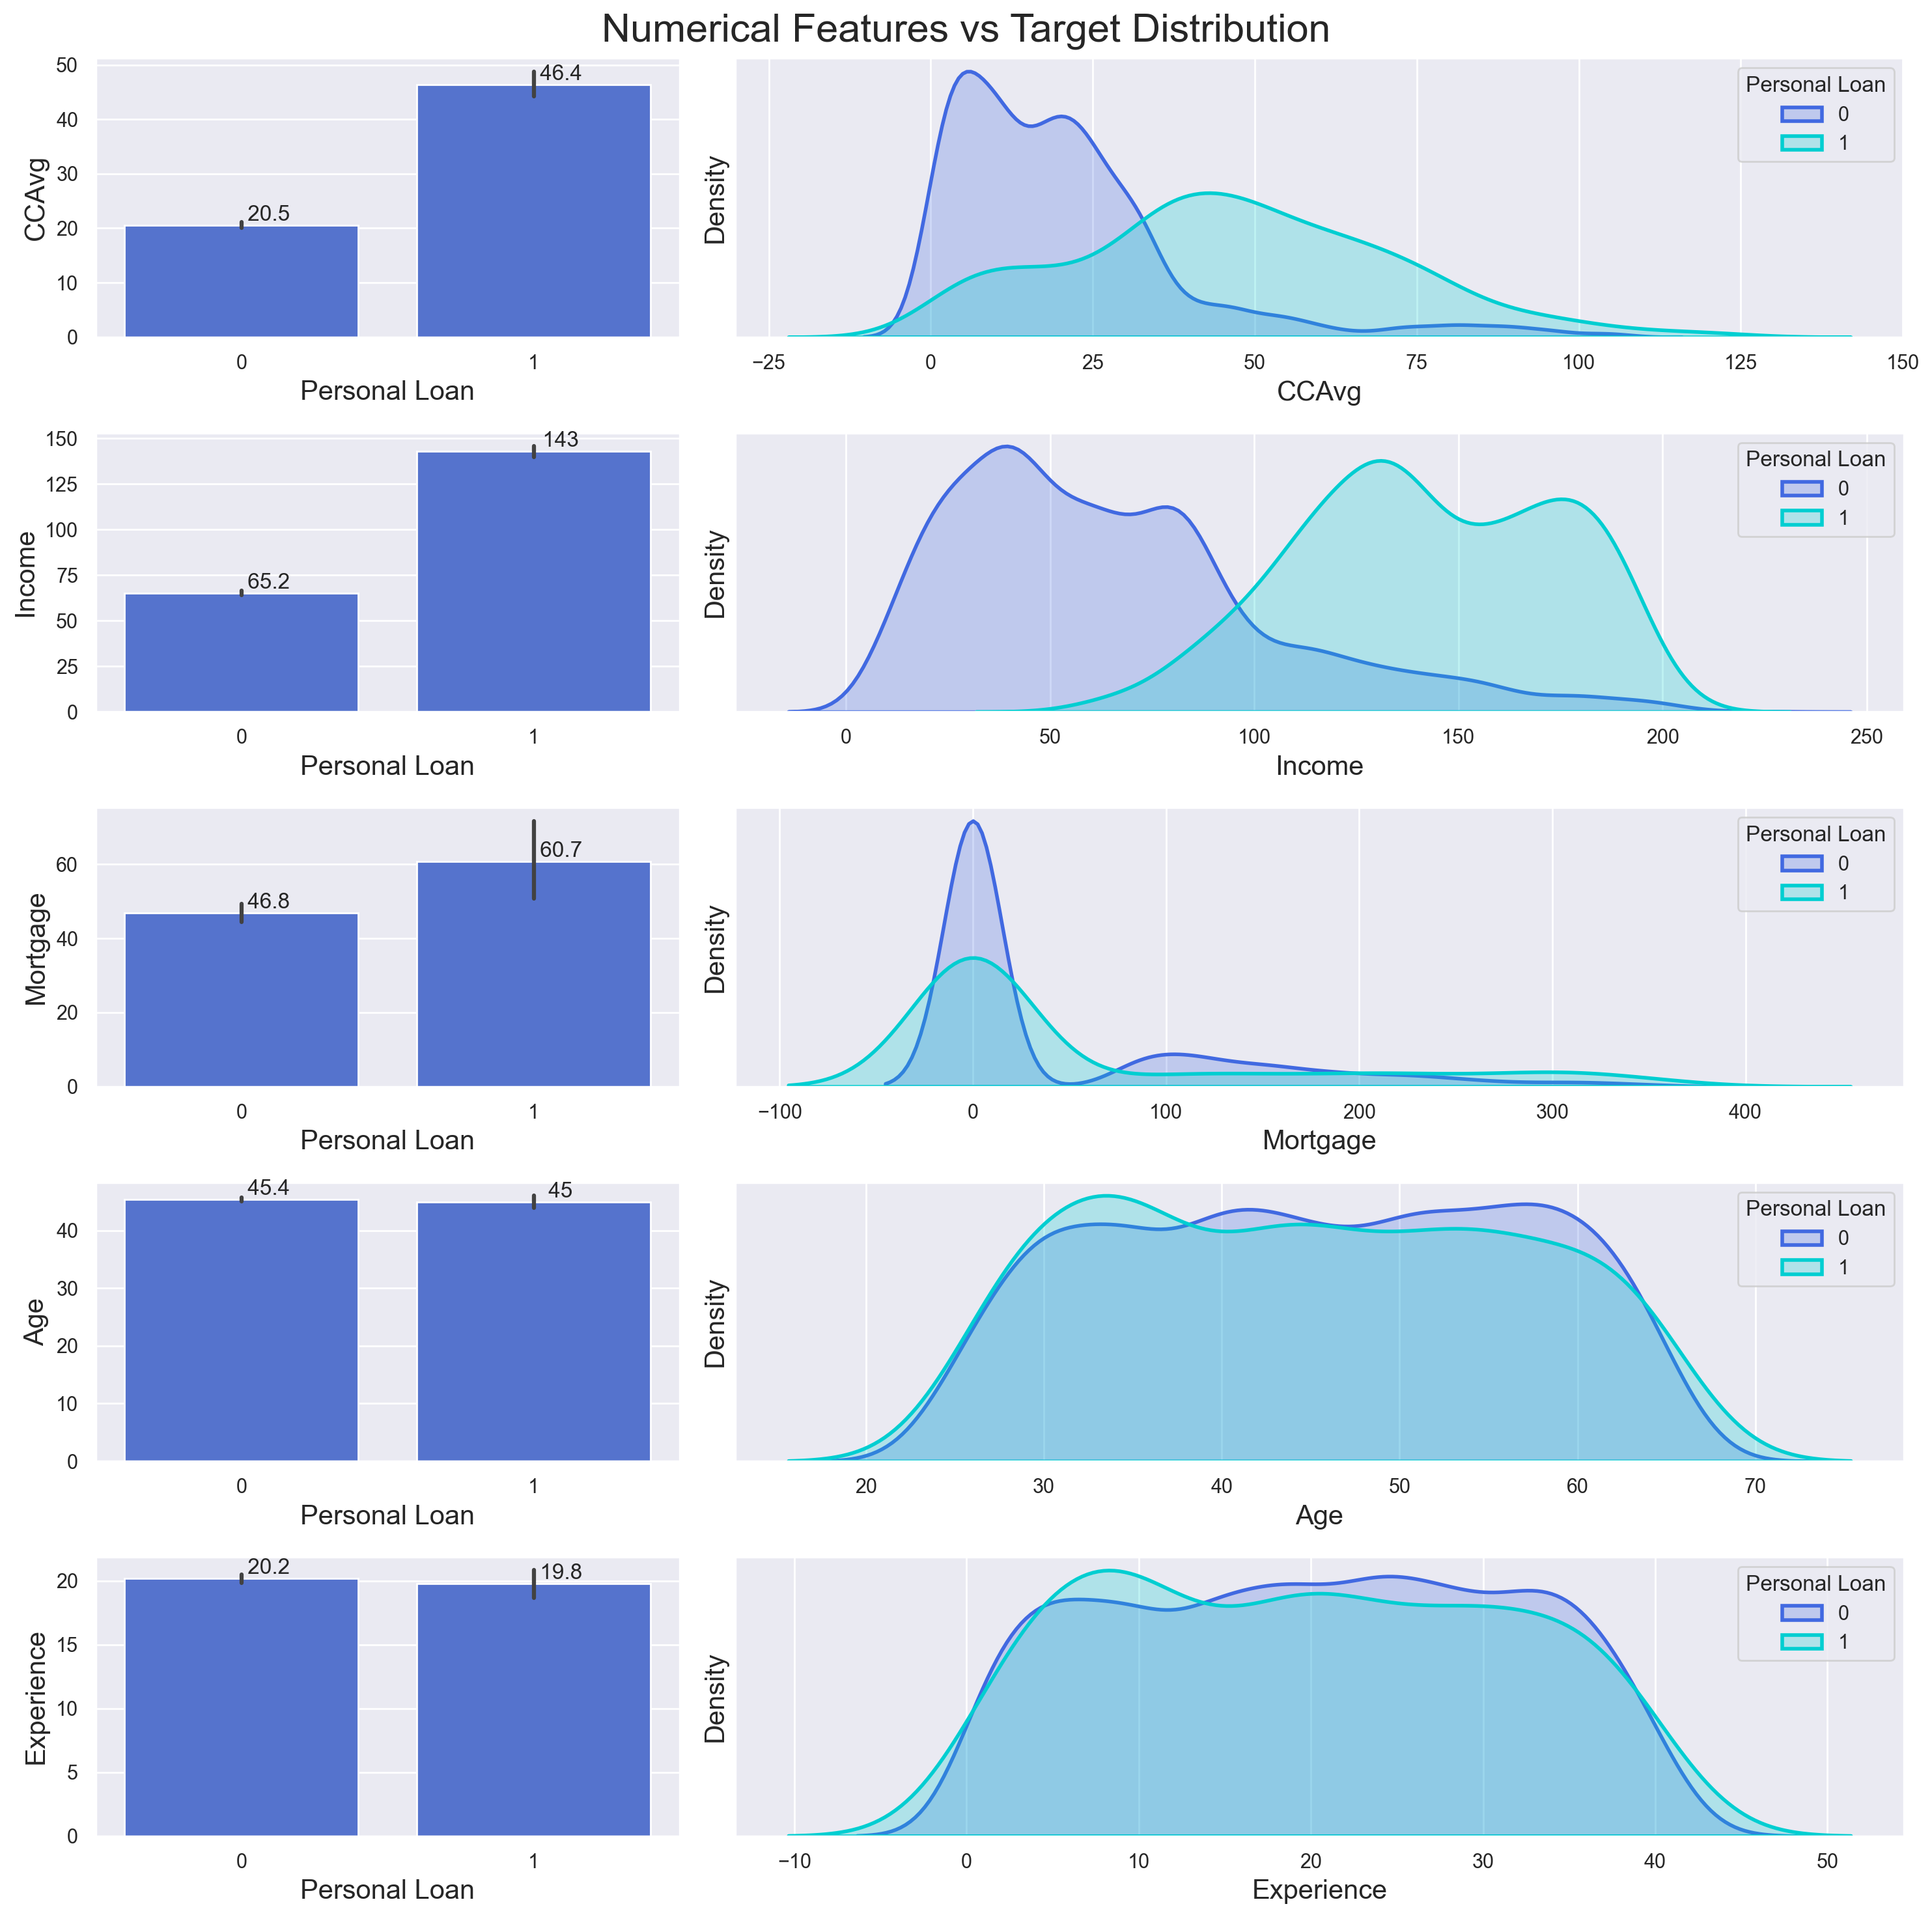

In [157]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

Customers who spend more on credit cards are more likely to take out personal loans.

Customers with high incomes are more likely to purchase a personal loan.

Customers with a high mortgage value are more likely to purchase personal loans.

It can be inferred that the age of customers has no influence on the probability of purchasing personal loans.

The effect of the amount of work experience on the purchase of a loan is similar to that of the age of the customer. The distribution of the Experience is very similar to the distribution of Age, as Experience is strongly correlated with Age.

Therefore, we remove Experience because it doesn't provide any more information than Age:

In [158]:
df.drop('Experience', axis=1, inplace=True)

In [159]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

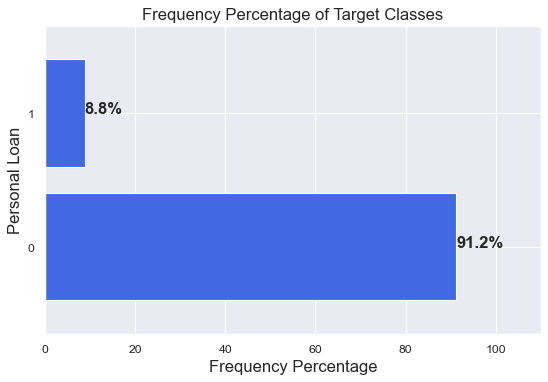

In [160]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

The dataset we are working on is imbalanced.

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided by parameter stratify.

For example: a binary categorical classification problem,

if y is the dependent variable or target\label column within dataframe following values:

0 25% data is zeros
1 75% data is ones
Then stratify=y will make sure that your random split has:

25% of 0's
75% of 1's

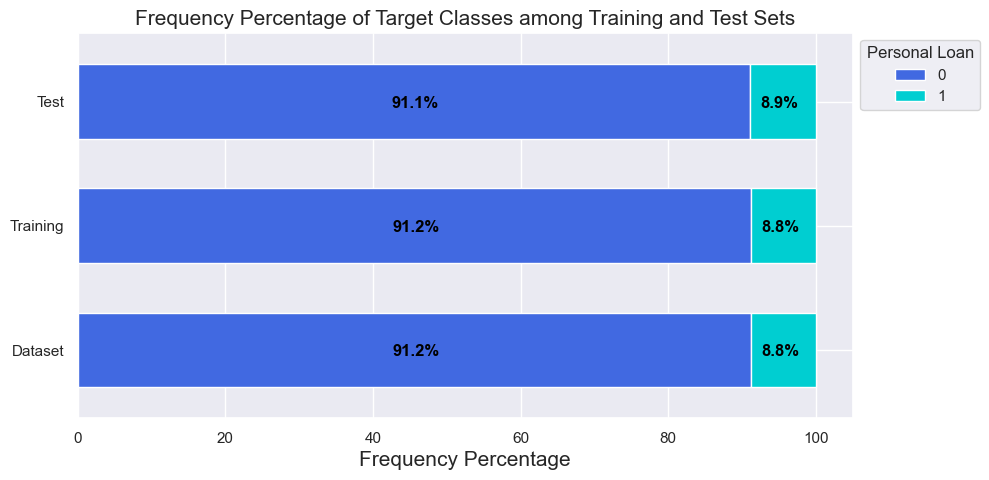

In [162]:
# Define a dataframe containing frequency percentages
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot frequency percentages barplot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()  

As seen, the samples are randomly divided in such a way that the proportion of each class remains the same across both the training and test sets.

In [163]:
scaler=StandardScaler()
scaled_X_train =scaler.fit_transform(X_train)
scaled_X_test=scaler.transform(X_test)

In [164]:
# test_error_rates=[]

# for k in range (1,30):
#     knn_model=KNeighborsClassifier(n_neighbors=k)
#     knn_model.fit(scaled_X_train,y_train)
    
#     y_pred_test=knn_model.predict(scaled_X_test)
    
#     test_error=1-accuracy_score(y_test,y_pred_test)
#     test_error_rates.append(test_error)

In [165]:
# test_error_rates

In [166]:
# plt.plot(range(1,30),test_error_rates)
# plt.ylabel('Error rate')
# plt.xlabel('K Neighbours')

Optimal value of K is 3, the error is least there

In [167]:
scaler=StandardScaler()
knn=KNeighborsClassifier()

In [168]:
operations=[('scaler',scaler),('knn',knn)]

In [169]:
pipe=Pipeline(operations)

In [170]:
k_values=list(range(1,10))

param_grid={'knn__n_neighbors':k_values}

full_cv_classifier=GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [171]:
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [172]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=3))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=3),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 3,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [173]:
full_pred=full_cv_classifier.predict(X_test)

In [174]:
print(classification_report(y_test,full_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       892
           1       0.94      0.59      0.72        87

    accuracy                           0.96       979
   macro avg       0.95      0.79      0.85       979
weighted avg       0.96      0.96      0.96       979



In [176]:
# Save the model (ensure this was done properly)
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Assuming 'model' is your trained KNN model
with open('knn_model.pkl', 'wb') as model_file:
    pickle.dump(full_cv_classifier, model_file)

# Load the model
with open('knn_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)


In [177]:
with open('knn_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

print(type(model))  # This should print the type of the model, e.g., <class 'sklearn.neighbors._classification.KNeighborsClassifier'>


<class 'sklearn.model_selection._search.GridSearchCV'>
